In [ ]:
import time
from textwrap import wrap

import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras import Input
from tensorflow.keras.layers import (
  GRU,
  Dense,
  Add,
	AdditiveAttention,
  Attention,
  Embedding,
  LayerNormalization,
	Reshape,
	StringLookup,
	TextVectorization,
  Concatenate,
)



In [ ]:
# ----------> Next
# change this to control the accuracy/speed
COCAB_SIZE = 20000 # use fewer words to speed up convergence
ATTENTION_DIM = 512 # size of dense layer in attention
XXX_EMBEDDING_DIM = 128

# InceptionRestNetV2 takes (299, 299,3) image as inputs
# and return features in (8,8,1536) shape
FEATURE_EXTRACTOR = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
	include_top = False, weights="imagenet"
)

IMG_HEIGHT = 299
IMG_WIDTH  = 299
IMG_CHANNELS = 3
FEATURE_SHAPE = (8,8,1536)


219055592/219055592 [==============================] - 1s 0us/step


In [ ]:

GCS_DIR = "gs://asl-public/data/tensorflow_datasets/"
BUFFER_SIZE = 1000

def get_image_label(example):
	caption = example["captions"]["text"][0] # only 1st caption per image
	img = example["image"]
	img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
	img = img / 255

	return {"image_tensor" : img, "caption": caption}

trainds = tfds.load("coco_captions", split ="train", data_dir= GCS_DIR)
trainds = trainds.map(
 	get_image_label, num_parallel_calls= tf.data.AUTOTUNE
 ).shuffle(BUFFER_SIZE)

triands = trainds.prefetch(buffer_size = tf.data.AUTOTUNE)


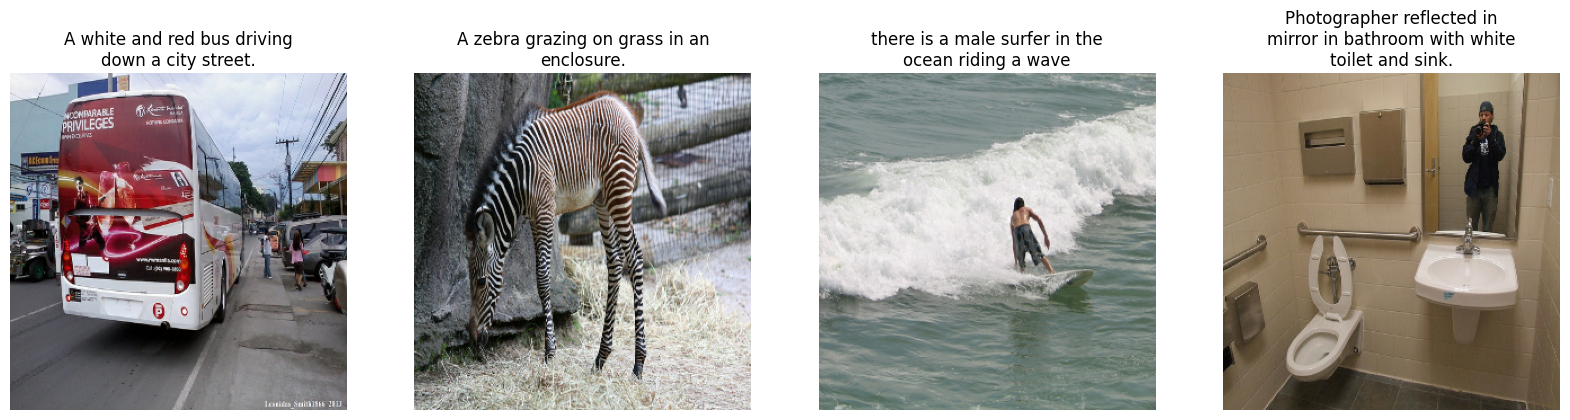

In [ ]:
#-----------> Next Visualize
f, ax = plt.subplots(1,4, figsize=(20,5))
for idx, data in enumerate(trainds.take(4)):
	ax[idx].imshow(data["image_tensor"].numpy())
	caption = "\n".join(wrap(data["caption"].numpy().decode("utf-8"), 30))
	ax[idx].set_title(caption)
	ax[idx].axis("off")

In [ ]:
#-----------> Next Text Processing
def add_start_end_token(data):
	start = tf.convert_to_tensor("<start>")
	end   = tf.convert_to_tensor("<end>")
	data["caption"] = tf.strings.join(
		[start, data["caption"], end], separator=""
	)

	return data

trainds = trainds.map(add_start_end_token)


In [ ]:
#-------> Next Tokenize the caption
MAX_CAPTION_LEN = 64
VOCAB_SIZE = 20 #-- check the size (TODO: smn)

def standardize(inputs):
   inputs = tf.strings.lower(inputs)

	 return tf.strings.regex_replace(
	 					 inputs, r"[!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_'{|}~]?",""
   )

tokenizer = TextVectorization(
	max_tokens = VOCAB_SIZE,
	standardize=standardize,
	output_sequence_length = MAX_CAPTION_LEN,
)

tokenizer.adapt(trainds.map(lambda x: x["caption"]))


In [ ]:
# ------------> Next (after long run)
tokenizer(["<start> This is a sentence <end>"])


<tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[ 1,  1, 10,  2,  1, 13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])>

In [ ]:
# ----------> Next
sample_captions = []
for d in trainds.take(5):
    sample_captions.append(d["caption"].numpy().decode("utf-8"))

sample_captions


['<start>The room is filled with remarkable items well suited.\n<end>',
 '<start>A number of teddy bears in a shopping basket<end>',
 '<start>A man is sitting at his desk and eating lunch.<end>',
 '<start>A group of young men standing next to each other watching a man skateboard.<end>',
 '<start>A messy computer workstation covered with papers and office supplies.<end>']

In [ ]:
#--------> Next Create converters
for wordid in tokenizer([sample_captions[0]])[0]:
	print(tokenizer.get_vocabulary()[wordid], end=" ")


[UNK] [UNK] is [UNK] with [UNK] [UNK] [UNK] [UNK] <end>                                                       

In [ ]:
#--------Next
word_to_index = StringLookup(
	mask_token="", vocabulary=tokenizer.get_vocabulary()
)

# table lookup: Index -> Word
index_to_word = StringLookup(
	mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True
)

In [ ]:

# ------------> Next : Create Dataset for Traning

BATCH_SIZE = 32

def create_ds_fn(data):
	img_tensor = data["image_tensor"]
	caption = tokenizer(data["caption"])

	target = tf.roll(caption, -1, 0)
	zeros  = tf.zeros([1], dtype=tf.int64)
	target = tf.concat((target[:-1], zeros), axis = -1)

	return (img_tensor, caption), target

batched_ds = (
  	triands.map(create_ds_fn)
	  .batch(BATCH_SIZE, drop_remainder = True)
	  .prefetch(buffer_size=tf.data.AUTOTUNE)
)


In [ ]:
#-------------> Next

for (img, caption), label in batched_ds.take(2):
	print(f"image shape: {img.shape}")
	print(f"Caption shape : {caption.shape}")
	print(f"Label shape : {label.shape}")
	print(caption[0])
	print(label[0])


image shape: (32, 299, 299, 3)
Caption shape : (32, 64)
Label shape : (32, 64)
tf.Tensor(
[ 2  1  1 10  1  1  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(64,), dtype=int64)
tf.Tensor(
[ 1  1 10  1  1  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(64,), dtype=int64)
image shape: (32, 299, 299, 3)
Caption shape : (32, 64)
Label shape : (32, 64)
tf.Tensor(
[ 2  1  1  8  1 17  1  5  7  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(64,), dtype=int64)
tf.Tensor(
[ 1  1  8  1 17  1  5  7  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

In [ ]:
#------>Next (Image Encoder)

FEATURE_EXTRACTOR.trainable = False
image_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
image_features = FEATURE_EXTRACTOR(image_input)

x = Reshape((FEATURE_SHAPE[0] * FEATURE_SHAPE[1], FEATURE_SHAPE[2]))(
	image_features
)

encoder_output = Dense(ATTENTION_DIM, activation="relu")(x)


In [ ]:
#---->Next
encoder = tf.keras.Model(inputs=image_input, outputs=encoder_output)
encoder.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_resnet_v2 (Funct  (None, None, None, 1536   54336736  
 ional)                      )                                   
                                                                 
 reshape_1 (Reshape)         (None, 64, 1536)          0         
                                                                 
 dense_2 (Dense)             (None, 64, 512)           786944    
                                                                 
Total params: 55123680 (210.28 MB)
Trainable params: 786944 (3.00 MB)
Non-trainable params: 54336736 (207.28 MB)
_________________________________________________________________


In [ ]:
#--------->Next (Image Decoder)

word_input = Input(shape=(1,), dtype=tf.int64, name = "words")
embed_x = Embedding(VOCAB_SIZE, ATTENTION_DIM)(word_input)

decoder_gru = GRU(
    ATTENTION_DIM, return_sequences=True, return_state=True
)

gru_output, gru_state = decoder_gru(embed_x)

decoder_attention = Attention()
context_vector = decoder_attention([gru_output, encoder_output])

addition = Add()([gru_output, context_vector])

layer_norm = LayerNormalization(axis=-1)
layer_norm_out = layer_norm(addition)

decoder_output_dense = Dense(VOCAB_SIZE)
decoder_output = decoder_output_dense(layer_norm_out)


In [ ]:
#----------Next
decoder = tf.keras.Model(
	inputs = [word_input, encoder_output], outputs = decoder_output
)
tf.keras.utils.plot_model(decoder)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
#----------Next - Summary
decoder.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 words (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 512)               10240     ['words[0][0]']               
                                                                                                  
 gru_1 (GRU)                 [(None, 1, 512),             1575936   ['embedding_1[2][0]']         
                              (None, 512)]                                                        
                                                                                                  
 input_7 (InputLayer)        [(None, 64, 512)]            0         []                      

In [ ]:
#------->Next (tarining the Model)

image_caption_train_model = tf.keras.Model(
	inputs = [image_input, word_input], outputs=decoder_output
)

In [ ]:

#--------> Next : LOSS Function
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
	from_logits = True, reduction = "none"
)

def loss_function(real, pred):
	loss_ = loss_object(real, pred)

	mask = tf.math.logical_not(tf.math.equal(real,0))
	mask = tf.cast(mask, dtype=tf.int32)
	sentense_len = tf.reduce_sum(mask)
	loss_ = loss_[:sentense_len]

	return tf.reduce_mean(loss_, 1)

In [ ]:
#----------- Next
image_caption_train_model.compile(
	optimizer="adam",
	loss=loss_function,
)


In [ ]:
#---------Next: Training Loop
%%time
history = image_caption_train_model.fit(batched_ds, epochs=1)


 213/2586 [=>............................] - ETA: 9:30:57 - loss: 0.3208